<a href="https://colab.research.google.com/github/nikhildr22/Speech-Emotion-Recognition/blob/master/newCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!mkdir dataset
!mkdir clean
!ls

clean  dataset	gdrive	sample_data


In [0]:
!cp '/content/gdrive/My Drive/Final Year Project/Dataset/Audio_Speech_Actors_01-24.zip' .
print('data copying completed')

data copying completed


In [0]:
''' unzipping the dataset into the destination folder 'dataset' '''
!unzip -q Audio_Speech_Actors_01-24.zip -d dataset

In [0]:
# Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
# Emotions to be observed in our project
observed_emotions=['happy','sad','angry','neutral']

In [0]:
''' Installing soundfile module via pip '''
!pip install soundfile

In [0]:
''' importing required modules '''
import librosa
from tqdm import tqdm
import soundfile
from scipy.io import wavfile
import os, glob, pickle
import numpy as np
from scipy.fftpack import dct
import matplotlib.pyplot as plt

In [0]:
''' downsampling audio files to 16KHz and storing them in /clean directory ''' 
for f in tqdm(glob.glob("dataset/*/*")):
    signal, rate = librosa.load(path=f, sr=16000)
    wavfile.write(filename='clean/'+f[-24:],rate=rate,data=signal)

100%|██████████| 1440/1440 [05:34<00:00,  4.30it/s]


In [0]:
''' Creating a pandas dataframe for structured handling of files in the dataset '''
import pandas as pd
#Dataframe will contain 2 columns 'file' and 'emotion'
dataframe = pd.DataFrame(columns=['file', 'emotion'])

In [0]:
''' filling the dataframe rows with values '''
for file in tqdm(glob.glob("clean/*")):
    file_name=os.path.basename(file[-24:])
    emotion=emotions[file_name.split("-")[2]]
    if emotion not in observed_emotions:
        continue

    dataframe = dataframe.append({'file': file, 'emotion': emotion}, ignore_index=True)

100%|██████████| 1440/1440 [00:01<00:00, 881.32it/s]


In [0]:
''' having a glimpse of how the dataframe looks ''' 
dataframe.head()

,file,emotion
0,clean/03-01-05-02-01-01-22.wav,angry
1,clean/03-01-03-01-02-02-07.wav,happy
2,clean/03-01-03-02-01-01-20.wav,happy
3,clean/03-01-01-01-02-02-12.wav,neutral
4,clean/03-01-04-01-01-02-11.wav,sad


In [0]:
''' Dividing the dataframe into test and train dataframes '''
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataframe, test_size=0.2)

In [0]:
print("Total number of audio files: ",len(dataframe))
print("Number of audio files in Train data: ",len(train))
print("Number of audio files in Testing data: ",len(test))

Total number of audio files:  672
Number of audio files in Train data:  537
Number of audio files in Testing data:  135


In [0]:
''' Defining a function for MFCC feature extraction '''

def find_mfcc(signal, sample_rate , numcep):
    pre_emphasis = 0.97
    emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
    frame_size = 0.025
    frame_stride = 0.01

    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]

    NFFT = 512
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

    nfilt = 40
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks)  # dB

    num_ceps = numcep
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-27
   
    return mfcc

In [0]:
''' preparing the training data for the model '''
x_train = []
y_train = []
for index,row in tqdm(train.iterrows()):
    file = row['file']
    emotion = row['emotion']
    with soundfile.SoundFile(file) as sound_file:
        signal = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        mfcc = np.mean(find_mfcc(signal, sample_rate, 26), axis=0)
        x_train.append(mfcc)
        y_train.append(emotion)


537it [00:05, 97.85it/s]


In [0]:
''' preparing the testing data for the model '''
x_test = []
y_test = []
for index,row in tqdm(test.iterrows()):
    file = row['file']
    emotion = row['emotion']
    with soundfile.SoundFile(file) as sound_file:
        signal = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        mfcc = np.mean(find_mfcc(signal, sample_rate, 26), axis=0)
        x_test.append(mfcc)
        y_test.append(emotion)

135it [00:01, 99.80it/s]


In [0]:
''' converting all the training and testing data into numpy arrays '''
x_test = np.array(x_test)
y_test = np.array(y_test)
x_train = np.array(x_train)
y_train = np.array(y_train)

In [0]:
'''Performing LabelEncoding for the categorical output data '''
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
y_train = label.fit_transform(y_train)
y_test = label.fit_transform(y_test)

In [0]:
print('This is how label encoded output looks:')
print(y_test[0:5])

This is how label encoded output looks:
[0 1 3 1 1]


In [0]:
''' Performing One hot encoding '''
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

Using TensorFlow backend.


In [0]:
print('This is how one hot encoded output looks:')
print(y_test[0:5])

This is how one hot encoded output looks:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


In [0]:
print('These are the dimentions of the data')
print('x_train shape = ',x_train.shape)
print('y_train shape = ',y_train.shape)
print('x_test shape = ',x_test.shape)
print('y_test shape = ',y_test.shape)

These are the dimentions of the data
x_train shape =  (537, 26)
y_train shape =  (537, 4)
x_test shape =  (135, 26)
y_test shape =  (135, 4)


In [0]:
num_features = x_train.shape[1]
# Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 26


In [0]:
''' imports required for MLP classifier '''
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [0]:
#Initializing the Multi Layer Perceptron Classifier
MLP_model = MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, 
                    hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=200,verbose=1)

In [0]:
#Training the model
MLP_model.fit(x_train,y_train)

Iteration 1, loss = 5.70778600
Iteration 2, loss = 3.16823951
Iteration 3, loss = 3.36755202
Iteration 4, loss = 3.21583873
Iteration 5, loss = 2.77490039
Iteration 6, loss = 2.41247365
Iteration 7, loss = 2.44346508
Iteration 8, loss = 2.33710970
Iteration 9, loss = 2.07026740
Iteration 10, loss = 2.09989137
Iteration 11, loss = 2.02367976
Iteration 12, loss = 1.89115059
Iteration 13, loss = 1.90724276
Iteration 14, loss = 1.83768987
Iteration 15, loss = 1.78339356
Iteration 16, loss = 1.77003750
Iteration 17, loss = 1.74109770
Iteration 18, loss = 1.69738043
Iteration 19, loss = 1.68329048
Iteration 20, loss = 1.62913243
Iteration 21, loss = 1.62589881
Iteration 22, loss = 1.60312943
Iteration 23, loss = 1.57735749
Iteration 24, loss = 1.54584194
Iteration 25, loss = 1.55396815
Iteration 26, loss = 1.54532143
Iteration 27, loss = 1.49204764
Iteration 28, loss = 1.47942347
Iteration 29, loss = 1.45439479
Iteration 30, loss = 1.45369484
Iteration 31, loss = 1.42849775
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.01, batch_size=256, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(300,), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=1, warm_start=False)

In [0]:
#Predicting the results for the train set data
y_pred=MLP_model.predict(x_train)
#Calculatng the training accuracy of the model
accuracy=accuracy_score(y_true=y_train, y_pred=y_pred)
#Print the accuracy
print("Training Accuracy: {:.2f}%".format(accuracy*100))

Training Accuracy: 94.60%


In [0]:
#Predicting the results for the test set data
y_pred=MLP_model.predict(x_test)
#Calculatng the testing accuracy of the model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
#Print the accuracy
print("Testing Accuracy: {:.2f}%".format(accuracy*100))

Testing Accuracy: 57.78%


In [0]:
''' imports required for CNN model '''
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv1D,Flatten 
from tensorflow.keras.layers import MaxPooling1D,Dropout

In [0]:
''' reshaping data before feeding into the model '''
input_shape = (num_features,1)
num_files = x_train.shape[0]
x_train = x_train.reshape(num_files,num_features,1)

In [0]:
''' CNN model '''
cnn_model = Sequential()
cnn_model.add(Conv1D(32, kernel_size=(3), input_shape=input_shape))
cnn_model.add(Conv1D(64, kernel_size=(3)))
cnn_model.add(Conv1D(128, kernel_size=(3)))
cnn_model.add(MaxPooling1D(3))
cnn_model.add(Conv1D(64, kernel_size=(3)))
cnn_model.add(Conv1D(32, kernel_size=(3)))
cnn_model.add(Flatten())
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(12, activation='relu'))
cnn_model.add(Dense(4, activation='softmax'))

In [0]:
''' compiling the model and printing summary '''
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 24, 32)            128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 22, 64)            6208      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 20, 128)           24704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 6, 128)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4, 64)             24640     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 2, 32)             6176      
_________________________________________________________________
flatten (Flatten)            (None, 64)                0

In [0]:
''' CNN model training '''
final = cnn_model.fit(x_train, y_train, epochs=500,verbose=1, batch_size=256, validation_split=0.2)

Epoch 1/500
2/2 [==============================] - 0s 213ms/step - loss: 2.6098 - accuracy: 0.1515 - val_loss: 1.4362 - val_accuracy: 0.1852
Epoch 2/500
2/2 [==============================] - 0s 17ms/step - loss: 1.5610 - accuracy: 0.1935 - val_loss: 1.3896 - val_accuracy: 0.3519
Epoch 3/500
2/2 [==============================] - 0s 16ms/step - loss: 1.4710 - accuracy: 0.2145 - val_loss: 1.3485 - val_accuracy: 0.3148
Epoch 4/500
2/2 [==============================] - 0s 16ms/step - loss: 1.3911 - accuracy: 0.2960 - val_loss: 1.3318 - val_accuracy: 0.2870
Epoch 5/500
2/2 [==============================] - 0s 16ms/step - loss: 1.3778 - accuracy: 0.3240 - val_loss: 1.3187 - val_accuracy: 0.3148
Epoch 6/500
2/2 [==============================] - 0s 16ms/step - loss: 1.3565 - accuracy: 0.3217 - val_loss: 1.2786 - val_accuracy: 0.3796
Epoch 7/500
2/2 [==============================] - 0s 16ms/step - loss: 1.3034 - accuracy: 0.3846 - val_loss: 1.2614 - val_accuracy: 0.5093
Epoch 8/500
2/2 [==

In [0]:
''' reshaping testing data before feeding into the model '''
num_testfiles = y_test.shape[0]
x_test = x_test.reshape(num_testfiles,num_features,1)

In [0]:
acc = final.history['accuracy'][-1] * 100
print('Training accuracy of the CNN model: {:.2f}%'.format(acc))

Training accuracy of the CNN model: 97.90%


In [0]:
''' evaluating the testing accuracy for the trained model '''
test_loss,test_accuracy = cnn_model.evaluate(x_test, y_test)
print('Testing accuracy is : {:.2f}%'.format(test_accuracy*100))

5/5 [==============================] - 0s 16ms/step - loss: 2.4800 - accuracy: 0.6667
Testing accuracy is : 66.67%


In [0]:
''' imports required for playing sound files '''
import IPython.display as ipd

In [0]:
''' taking a random file from the testing data '''
random_data = test.sample()
file = random_data.iloc[0]['file']
print('file ',file[-24:])
original_emotion = random_data.iloc[0]['emotion']
ipd.Audio(filename=file,) # load a local WAV file

file  03-01-03-02-02-01-07.wav


In [0]:
def get_relation(index,value):
    emo = label.inverse_transform([index])[0]
    value = float(value) * 100
    return '{} - {:.10f}%'.format(emo,value)

In [0]:
''' extracting features and feeding it to the model for prediction '''
with soundfile.SoundFile(file) as sound_file:
    signal = sound_file.read(dtype="float32")
    sample_rate=sound_file.samplerate
    feature = np.mean(find_mfcc(signal, sample_rate, 26), axis=0)
result = cnn_model.predict(feature.reshape(1,num_features,1))
for index,i in enumerate(result[0]):print(get_relation(index,i))
result = cnn_model.predict_classes(feature.reshape(1,num_features,1))
print('Original emotion is : ' + original_emotion)
print('identified emotion is : ' + label.inverse_transform(result)[0])

angry - 99.7082293034%
happy - 0.0584031513%
neutral - 0.2324130619%
sad - 0.0009455497%
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Original emotion is : happy
identified emotion is : angry


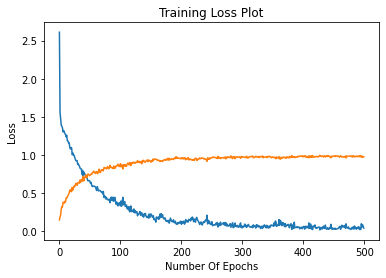

In [0]:
plt.plot(final.history['loss'])

plt.ylabel('Loss')
plt.xlabel('Number Of Epochs')
plt.title('Training Loss Plot')
plt.show()

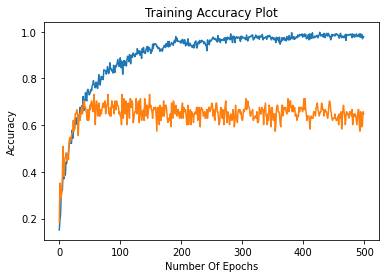

In [0]:
plt.plot(final.history['accuracy'])

plt.ylabel('Accuracy')
plt.xlabel('Number Of Epochs')
plt.title('Training Accuracy Plot')
plt.show()

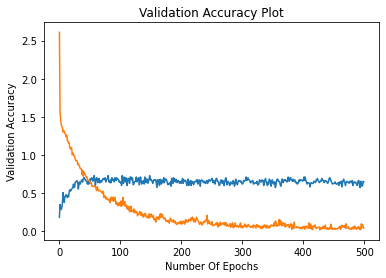

In [0]:
plt.plot(final.history['val_accuracy'])


plt.ylabel('Validation Accuracy')
plt.xlabel('Number Of Epochs')
plt.title('Validation Accuracy Plot')
plt.show()

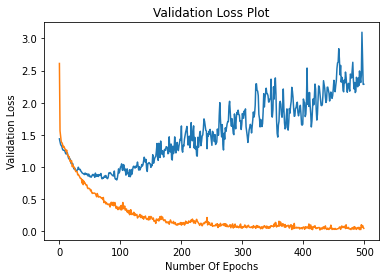

In [0]:
plt.plot(final.history['val_loss'])
plt.plot(final.history['loss'])
plt.ylabel('Validation Loss')
plt.xlabel('Number Of Epochs')
plt.title('Validation Loss Plot')
plt.show()

In [0]:
y_pred = cnn_model.predict_classes(x_test.reshape(len(x_test),num_features,1))
print('predicted values for the test data:')
print(label.inverse_transform(y_pred))

predicted values for the test data:
['angry' 'happy' 'neutral' 'neutral' 'happy' 'angry' 'sad' 'neutral'
 'angry' 'sad' 'neutral' 'happy' 'sad' 'sad' 'happy' 'neutral' 'sad'
 'happy' 'neutral' 'angry' 'sad' 'sad' 'neutral' 'happy' 'angry' 'sad'
 'angry' 'neutral' 'sad' 'neutral' 'neutral' 'happy' 'neutral' 'happy'
 'happy' 'neutral' 'neutral' 'neutral' 'sad' 'happy' 'neutral' 'neutral'
 'neutral' 'sad' 'sad' 'neutral' 'angry' 'sad' 'neutral' 'sad' 'happy'
 'angry' 'angry' 'happy' 'neutral' 'angry' 'angry' 'angry' 'sad' 'sad'
 'sad' 'neutral' 'angry' 'angry' 'angry' 'angry' 'neutral' 'sad' 'happy'
 'sad' 'angry' 'sad' 'sad' 'sad' 'happy' 'angry' 'neutral' 'angry' 'happy'
 'angry' 'happy' 'sad' 'angry' 'angry' 'sad' 'neutral' 'happy' 'angry'
 'angry' 'angry' 'happy' 'neutral' 'angry' 'neutral' 'happy' 'angry'
 'angry' 'sad' 'angry' 'sad' 'neutral' 'angry' 'neutral' 'sad' 'sad'
 'angry' 'happy' 'happy' 'sad' 'happy' 'angry' 'neutral' 'sad' 'angry'
 'happy' 'sad' 'happy' 'neutral' 'angry' 

In [0]:
compare_data = pd.DataFrame(columns=['File', 'Original Emotion', 'Predicted Emotion'])

In [0]:
for index,row in tqdm(test.iterrows()):
    file = row['file']
    emotion = row['emotion']
    with soundfile.SoundFile(file) as sound_file:
        signal = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        feature = np.mean(find_mfcc(signal, sample_rate, 26), axis=0)
        result = cnn_model.predict_classes(feature.reshape(1,num_features,1))
        result = label.inverse_transform(result)[0]
        compare_data = compare_data.append({'File': file, 'Original Emotion': emotion ,
                                            'Predicted Emotion':result }, ignore_index=True)

135it [00:05, 22.57it/s]


In [0]:
''' printing 10 random samples of prediction '''
print(compare_data.sample(10))

                               File Original Emotion Predicted Emotion
89   clean/03-01-04-02-01-01-22.wav              sad             angry
87   clean/03-01-03-02-01-01-23.wav            happy             angry
21   clean/03-01-04-01-02-01-23.wav              sad               sad
4    clean/03-01-03-02-01-01-17.wav            happy             happy
95   clean/03-01-05-02-01-01-14.wav            angry             angry
72   clean/03-01-04-01-02-01-13.wav              sad               sad
105  clean/03-01-05-02-02-02-20.wav            angry             angry
58   clean/03-01-04-01-02-02-11.wav              sad               sad
109  clean/03-01-05-02-01-02-10.wav            angry             happy
22   clean/03-01-03-01-02-02-02.wav            happy           neutral
